In [65]:
from   numpy.lib.stride_tricks import sliding_window_view as window
import numpy as np
import random

from   PIL import Image, ImageOps
import matplotlib.pyplot as plt
import glob

In [102]:
# Confidences were beconing shape (5,5,5) because they were being added to a (5, 5)
# and this happened right when a confidence got edited for the first time
# so the max diff is too low.
# or maybe changing confidence to add right will make it work
# in the improved diff_fn.
class PatternMatcher:
    def __init__(self,
        shape, 
        channels, 
        max_diff, 
        learning_rate = .02,
        diff_fn = None,
        train_mode = 'all'):
        """
        shape:         shape of the pattern
        channels:      channel depth for convolutional
        max_diff:      maximum difference accepted before creating new pattern
        learning_rate: speed at which patterns learn
        diff_fn:      function to compare a pattern and a sample
        
        """
        self.shape         = shape
        self.channels      = channels
        self.max_diff      = max_diff
        self.learning_rate = learning_rate
        self.diff_fn       = diff_fn or self.default_diff_fn

        self.pattern_shape = self.shape + (self.channels,)
        self.pattern_size  = np.prod(self.pattern_shape)
        self.patterns      = []
        self.confidence    = []

        # confidence encompasses all channels


    def train(self, sample):
        #TODO: use confidence in the diff_fn

        if (len(self.patterns) == 0):
            self.patterns.append(sample)
            self.confidence.append(np.ones(self.shape + (1,)))
            return

        differences = self.get_differences(sample)
        min_index   = np.argmin(differences)

        if differences[min_index] > self.max_diff:
            self.patterns.append(sample)
            self.confidence.append(np.ones(self.shape + (1,)))

        else:
            nearest_pattern = self.patterns[min_index]
            nearest_cmap    = self.confidence[min_index]

            # current confidence moves towards
            # Ideal confidence, if reinforced or undermined
            if (self.confidence[min_index].shape[-1] != 1):
                print('before: ', self.confidence[min_index].shape)

            self.confidence[min_index] = \
                (nearest_cmap * (1 - self.learning_rate)) + \
                np.expand_dims((1 - np.sum(self.diff_fn(nearest_pattern, sample), axis = -1) / self.channels) * self.learning_rate, -1)
            
            if (self.confidence[min_index].shape[-1] != 1):
                print(nearest_cmap.shape)
                print('after: ', self.confidence[min_index].shape)
                print(sample.shape)
                print(self.diff_fn(nearest_pattern, sample).shape)
                print((1 - (np.sum(self.diff_fn(nearest_pattern, sample), axis = -1) / self.channels) * self.learning_rate).shape)

            self.patterns[min_index] = \
                nearest_pattern * (1 - self.learning_rate) + \
                sample          * self.learning_rate


    def get_differences(self, sample):
        return [np.sum(self.diff_fn(pattern, sample) * confidence) 
                / np.sum(confidence) 
            for pattern, confidence in zip(self.patterns, self.confidence)]


    def default_diff_fn(self, pattern, sample):
        # any problems here, esp. when dealing with images,
        # may be due to using uint8 types, which can experience underflow / overflow
        return np.abs(pattern - sample)


In [67]:
simple_numbers = PatternMatcher((1,), 1, .1, .05)
graphs         = []
last_length    = 0

for i in range(10000):

    simple_numbers.train(random.random())

    if (len(simple_numbers.patterns) > last_length):
        last_length += 1
        graphs.append([])

    for i, graph in enumerate(graphs):
        graph.append(simple_numbers.patterns[i])
        
print(simple_numbers.patterns)
print(simple_numbers.confidence)
print(len(simple_numbers.patterns))

[0.5735842423996779, 0.44202066563756204, 0.9314764884301144, 0.17162691131513272, 0.07830744681584464, 0.29562328124554044, 0.689325696236429, 0.8165407057804936]
[array([[0.96765105]]), array([[0.96895958]]), array([[0.96708836]]), array([[0.97309885]]), array([[0.96574656]]), array([[0.96441328]]), array([[0.96469178]]), array([[0.97168593]])]
8


In [101]:
print((np.ones((5, 5, 1)) + np.ones((5, 5))).shape)

(5, 5, 5)


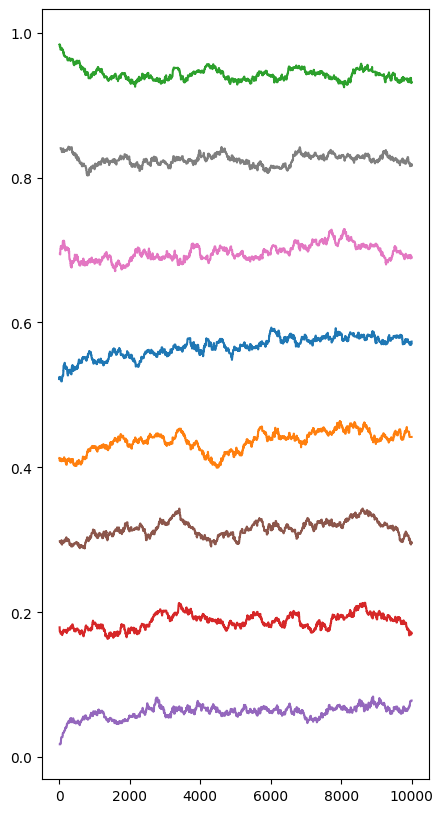

In [68]:
max_length = len(max(graphs, key = len))
plt.figure(figsize = (5, 10))

for graph in graphs:
    plt.plot(np.arange(max_length - len(graph), max_length), graph)

plt.show()

In [69]:
class ConvolutionalPatternMatcher(PatternMatcher):
    
    def get_activation_map(self, image):# image must be 0-1!
        
        activation_map = np.zeros(
            (image.shape[0] - self.shape[0] + 1,
             image.shape[1] - self.shape[1] + 1,
             len(self.patterns)))
        
        image_windows = np.squeeze(window(
            image, 
            (self.shape[0], self.shape[1],
            image.shape[-1])), axis = -4)

        for i, pattern in enumerate(self.patterns):
            activation_map[:, :, i] = 1 - (
                np.sum(np.abs(image_windows - pattern), axis = (2, 3, 4))
                ) / self.pattern_size

        return activation_map
    

    def undo_activation_map(self, activation_map, prune_nominators = 'max', combine_nominees = 'max'):

        #x, y, value
        image = np.zeros(
            (activation_map.shape[0] - 1 + self.shape[0],
             activation_map.shape[1] - 1 + self.shape[1],
             self.shape[-1]))
        
        # x, y, strength
        candidate_map = np.zeros(
            (activation_map.shape[0] - 1 + self.shape[0],
             activation_map.shape[1] - 1 + self.shape[1],
             self.shape[-1]))

        # keep only the max nominator and set its value to 1
        if prune_nominators == 'max':
            activation_map = activation_map == np.repeat(
                np.expand_dims(
                    np.max(activation_map, axis = -1),
                    -1
                    ),
                    activation_map.shape[-1], axis = -1
                )
        
        for n, pattern in enumerate(self.patterns):
            for x in range(activation_map.shape[0]):
                for y in range(activation_map.shape[1]):

                    if combine_nominees == 'max':
                        sample = candidate_map[x : x + self.shape[0], y : y + self.shape[1]]
                        mask = (activation_map[x, y, n] > sample) * 1
                        candidate_map[x : x + self.shape[0], y : y + self.shape[1]] = (sample * (1 - mask)) + (activation_map[x, y, n] * mask)
                        image[x : x + self.shape[0], y : y + self.shape[1]] = (image[x : x + self.shape[0], y : y + self.shape[1]] * (1 - mask)) + (pattern * mask)

                    if (combine_nominees == 'avg'):
                        sample = candidate_map[x : x + self.shape[0], y : y + self.shape[1]]
                        new_sample = sample + activation_map[x, y, n]
                        image[x : x + self.shape[0], y : y + self.shape[1]] *= (sample / new_sample)
                        image[x : x + self.shape[0], y : y + self.shape[1]] += pattern * (activation_map[x, y, n] / new_sample)

        return image

In [1]:
def get_train_images(aspect = (100, 70)):
    images = []

    for filename in glob.glob('images/*.jpg'): #assuming gif
        im = Image.open(filename)
        im = ImageOps.fit(im, aspect)
        im = np.array(im).astype(np.float32) / 255
        images.append(im)

    plt.figure(figsize = (8, 8))

    _, axarr = plt.subplots(2, 2) 
    axarr = axarr.flatten()


    for i, im in enumerate(random.sample(images, 4)):
        axarr[i].imshow(im)
        axarr[i].axis('off')
        axarr[i].margins(0, 0)

    plt.subplots_adjust(wspace=.05, hspace=.05, left=0, right=1, bottom=0, top=1)

    return images

In [71]:
def get_example(p):
    width  = p.shape[0]
    height = p.shape[1]

    image = random.choice(images)
    chunk = image[random.randint(0, image.shape[0] - width):, 
                    random.randint(0, image.shape[1] - height):]
    chunk = chunk[:width, :height]
    return chunk

<Figure size 800x800 with 0 Axes>

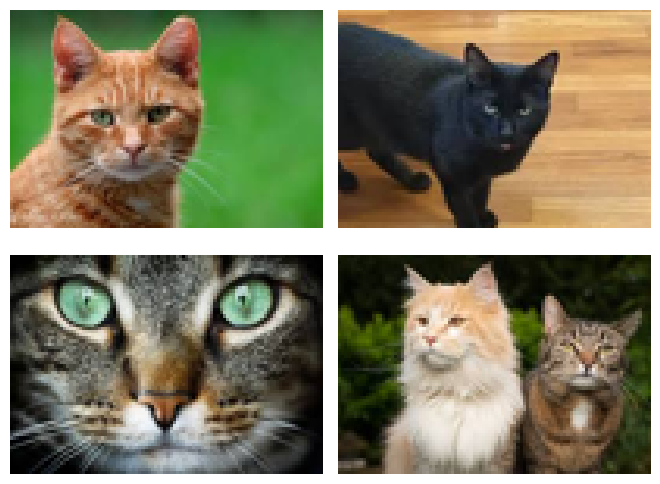

In [72]:
images = get_train_images()

In [108]:
p = PatternMatcher((5, 5), 3, .2, .05)
for i in range(1000):
    p.train(get_example(p))

In [109]:
len(p.patterns)

373

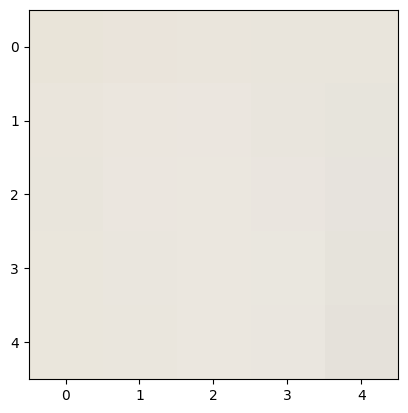

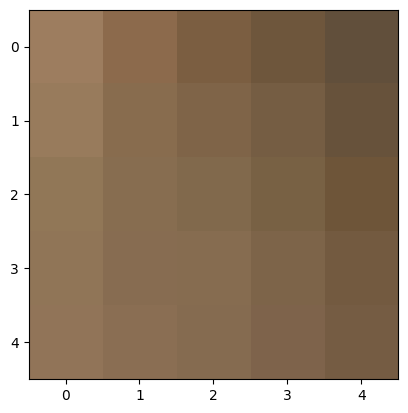

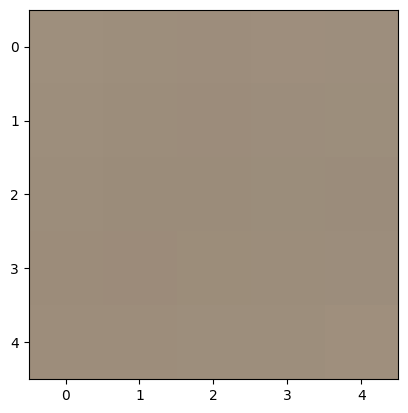

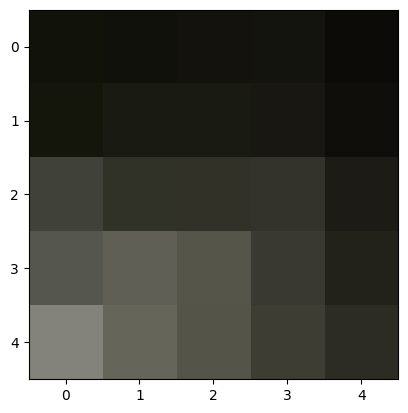

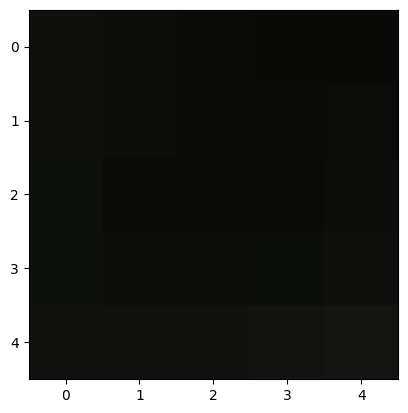

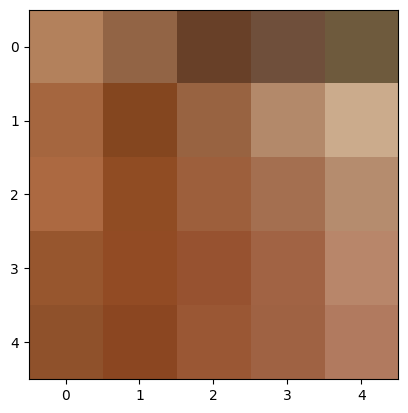

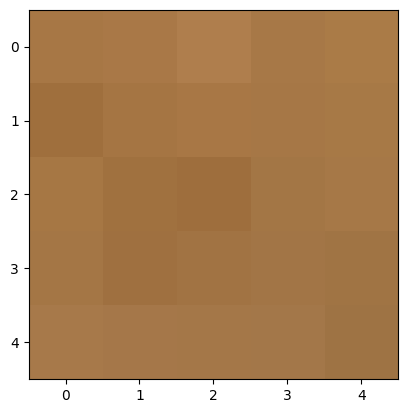

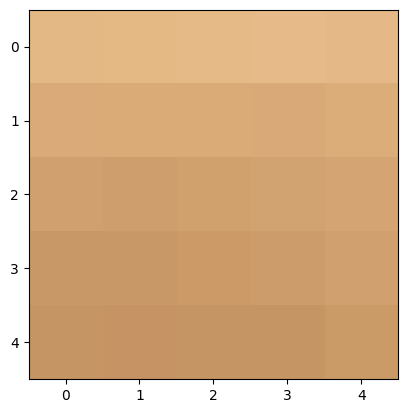

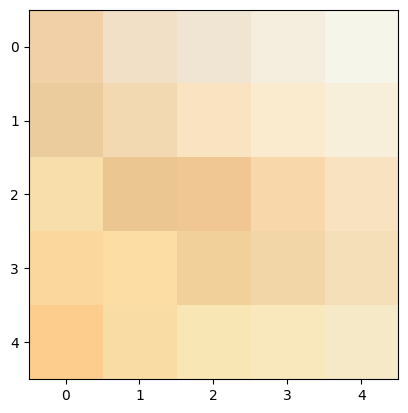

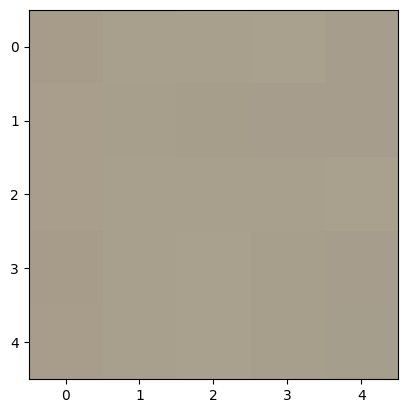

In [110]:
# if len(p.patterns) < 40:
for pattern, confidence in zip(p.patterns[:10], p.confidence[:10]):
    plt.imshow(pattern, alpha = np.squeeze(confidence))
    plt.show()

In [ ]:
act_map = p.get_activation_map(images[2])
plt.imshow(images[2])
plt.show()

AttributeError: 'PatternMatcher' object has no attribute 'get_activation_map'

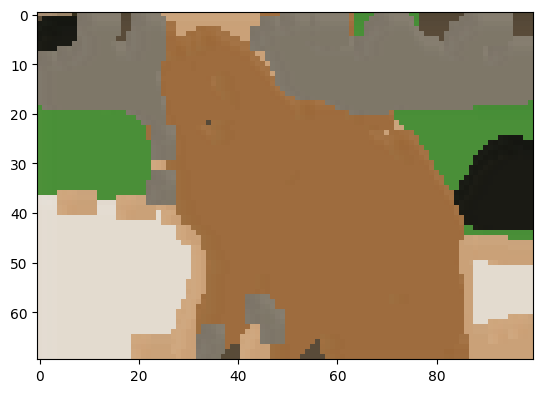

In [ ]:
plt.imshow(p.undo_activation_map(act_map))
plt.show()

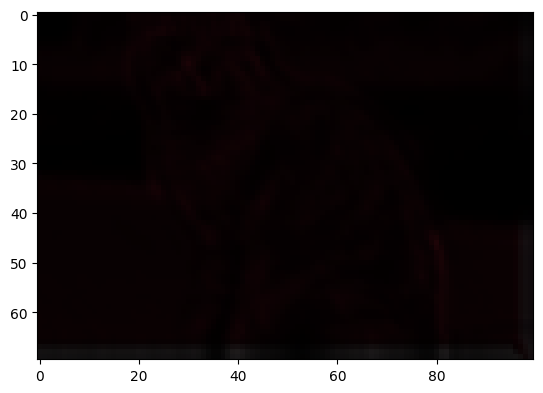

In [ ]:
plt.imshow(p.undo_activation_map(act_map, 'none', 'avg'))
plt.show()

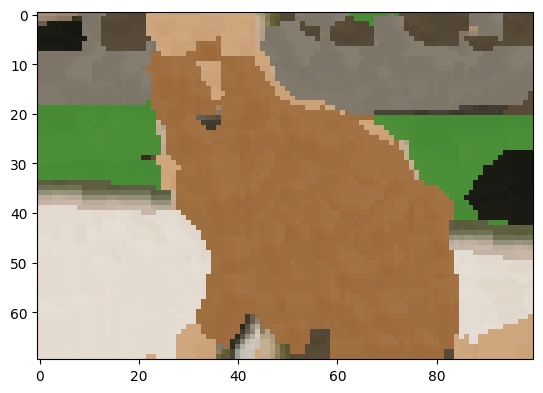

In [ ]:

plt.imshow(p.undo_activation_map(act_map, 'none'))
plt.show()